Load the LLM, in this case we are using gpt2

In [ ]:
#!pip install transformers

In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = True)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

c:\Users\Digital\anaconda3\envs\pymodelextractor_exp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# my_list = wrapper.alphabet
# for element in list(wrapper.alphabet.symbols)[7:]:
#     print(element, ':')
#     print(tokenizer.convert_tokens_to_ids(str(element)))
#     token = tokenizer.tokenize(str(element))
#     print(token)
#     print(tokenizer.convert_tokens_to_ids(token))
#     print(tokenizer.encode(str(element)))
#     print('----------------------------')

In [3]:
input_ids = torch.tensor([[1,2,3]])
id =5

In [4]:
input_ids = torch.cat([input_ids[0], torch.tensor([id])])

In [5]:
input_ids

tensor([1, 2, 3, 5])

In [6]:
tokenizer.decode(23154)

'ysics'

In [7]:
print(tokenizer.encode(str('astrophysics')))

[48782, 23154]


In [8]:
#!pip install --upgrade pillow

In [9]:
import sys
sys.path.append("../")

In [10]:
#!pip install ssl

In [11]:
from case_studies.gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.man_woman_wfa import alphabet

wrapper = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer)
#from utilities.mock_probabilistic_model import MockProbabilisticModel
#from pythautomata.base_types.symbol import SymbolStr
#terminal_symbol = SymbolStr(tokenizer.eos_token)
#wrapper = MockProbabilisticModel(alphabet, terminal_symbol)

In [12]:
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa
guiding_wfa = get_man_woman_wfa(wrapper.terminal_symbol)

In [13]:
from utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
guiding_generator = GuidingWDFASequenceGenerator(guiding_wfa, None)

In [14]:
guiding_generator.generate_words(10)

[The,woman,studied,art,
 The,woman,studied,maths,
 The,woman,studied,science,
 The,man,studied,astrophysics,
 The,man,studied,astrology,
 The,man,studied,science,
 The,woman,studied,music,
 The,man,studied,medicine,
 The,man,studied,maths,
 The,woman,studied,maths]

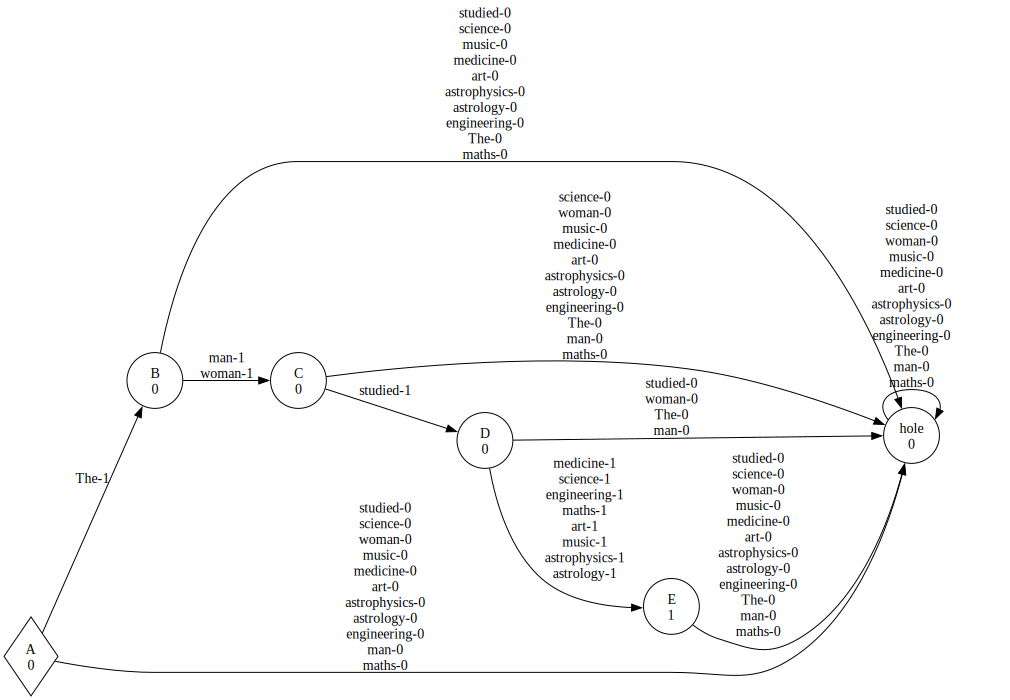

In [15]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa)

display(graph)

In [16]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa
property_model = get_man_woman_wfa(wrapper.terminal_symbol)
syncrhronic_model = SyncronicModelGuidedLanguageModel(wrapper, property_model, model_name="GUIDED_GPT2", max_seq_length=10,normalize_outputs=True)

In [17]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
partitioner = QuantizationProbabilityPartitioner(100000)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = guiding_generator
max_states = 30
max_query_length = 100


In [18]:
teacher  = PACProbabilisticTeacher(syncrhronic_model, epsilon = epsilon, delta = delta, max_seq_length = None, comparator = comparator, sequence_generator=guiding_generator, compute_epsilon_star=False)
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False)

In [19]:
learning_result = learner.learn(teacher, verbose=True)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
c:\Repos\pymodelextractor_model_guided_extraction\notebooks\..\utilities\syncronic_model_guided_language_model.py:128: RuntimeWarning: invalid value encountered in divide
  return list(np.array(probas)/np.sum(probas))


AssertionError: 

In [ ]:
from pythautomata.base_types.sequence import Sequence
from pythautomata.base_types.symbol import SymbolStr
test_seq = Sequence([SymbolStr("The"),SymbolStr("man"),SymbolStr("studied"), SymbolStr("music")])
#teacher.next_token_probabilities(test_seq)

In [ ]:
from collections import OrderedDict
def next_token_probabilities(model, sequence):
        symbols = list(model.alphabet.symbols)
        symbols.sort()
        symbols = [model.terminal_symbol] + symbols
        probabilities = model.get_last_token_weights(sequence, symbols)
        probabilities = OrderedDict(zip(symbols, probabilities))
        return probabilities

In [ ]:
from pythautomata.utilities.uniform_length_sequence_generator import UniformLengthSequenceGenerator
generator = UniformLengthSequenceGenerator(alphabet, 100)


In [ ]:
import numpy as np
res = list()
words = generator.generate_all_words()
for word in words:
    probs = list(next_token_probabilities(syncrhronic_model, word).values())
    if np.sum(probs) > 0:
        print(word, probs)
        res.append((word, probs))
    if len(res)>1000:
        break

In [ ]:
next_token_probabilities(wrapper, test_seq)

In [ ]:
next_token_probabilities(guiding_wfa, test_seq)

In [ ]:
next_token_probabilities(syncrhronic_model, test_seq)

In [ ]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(learning_result.model)

display(graph)